# Project 4A - Spray Analysis

In this notebook we will be analysing the repartition of mosquitoes throughout the years in the city of Chicago and compare it with the spray efforts that have been done in 2011 and 2013.

The purpose of this analysis is to measure the effectiveness of the spray efforts and provide recommendations on where and how to spray to optimize spraying.

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon


import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# Passing plotly map token
MAPBOX_TOKEN = 'pk.eyJ1IjoiZmNvbWJlbGxlczE4IiwiYSI6ImNsYmZ0MGNhdTA0cmIzdnBmejk0azF6ZzgifQ.b0AOPQEYA4koQBIPbkXeAA'

Importing relevant files and geographical maps

In [2]:
weather = pd.read_csv('data/datasets/weather.csv', parse_dates=True)
train = pd.read_csv('data/datasets/train.csv', parse_dates=True)
test = pd.read_csv('data/datasets/test.csv', parse_dates=True)
spray = pd.read_csv('data/datasets/spray_clean.csv', parse_dates=True)

# Importing Chicago boundary map
chicago = gpd.read_file('data/map/geo_export_c1136ecf-9473-4a42-8d0e-524480fe2323.shp')
crs = {'init': 'epsg:4326'}

Display file head and define Date format for data column

In [3]:
train.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [4]:
# Define format for date and split it

train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')

train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year

train['year_month'] = train['Date'].dt.strftime('%Y-%m')

In [5]:
# Display the years present in the dataset

train['year'].value_counts()

2007    3811
2013    2392
2009    2249
2011    2054
Name: year, dtype: int64

In [6]:
spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [7]:
# Define format for date and split it

spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')

spray['day'] = spray['Date'].dt.day
spray['month'] = spray['Date'].dt.month
spray['year'] = spray['Date'].dt.year

spray['year_month'] = spray['Date'].dt.strftime('%Y-%m')

* For 2011, spraying was done between August and September
* For 2013, spraying was done between July and September

In [8]:
spray

Date        Time   Latitude  Longitude  day  month  year  \
0     2011-08-29  6:56:58 PM  42.391623 -88.089163   29      8  2011   
1     2011-08-29  6:57:08 PM  42.391348 -88.089163   29      8  2011   
2     2011-08-29  6:57:18 PM  42.391022 -88.089157   29      8  2011   
3     2011-08-29  6:57:28 PM  42.390637 -88.089158   29      8  2011   
4     2011-08-29  6:57:38 PM  42.390410 -88.088858   29      8  2011   
...          ...         ...        ...        ...  ...    ...   ...   
14830 2013-09-05  8:34:11 PM  42.006587 -87.812355    5      9  2013   
14831 2013-09-05  8:35:01 PM  42.006192 -87.816015    5      9  2013   
14832 2013-09-05  8:35:21 PM  42.006022 -87.817392    5      9  2013   
14833 2013-09-05  8:35:31 PM  42.005453 -87.817423    5      9  2013   
14834 2013-09-05  8:35:41 PM  42.004805 -87.817460    5      9  2013   

      year_month  
0        2011-08  
1        2011-08  
2        2011-08  
3        2011-08  
4        2011-08  
...          ...  
14830    2013-09  
14831    2013-09  
14832    2013-09  
14833    2013-09  
14834    2013-09  

[14835 rows x 8 columns]

##### Create a new Dataframe

This new DataFrame will include the total number of mosquitos per address and the amount of time a trap has been detected as positive 

In [9]:
# New DataFrame with total number of mosquitos per address

mosquito_count = train.groupby(['Address'], as_index = False)[['NumMosquitos']].sum()
areas = train.groupby(['Address'], as_index = False)[['Latitude','Longitude']].median()
wnv = train.groupby(['Address'], as_index = False)[['WnvPresent']].sum()
y = train.groupby(['Address'], as_index = False)[['year']].median()
m = train.groupby(['Address'], as_index = False)[['month']].median()

mosquito_areas_wnv = pd.concat([mosquito_count,areas, wnv, y, m], axis = 1)
#mosquito_areas_wnv.drop('Address', axis = 1, inplace = True)

In [10]:
mosquito_areas_wnv.columns

Index(['Address', 'NumMosquitos', 'Address', 'Latitude', 'Longitude',
       'Address', 'WnvPresent', 'Address', 'year', 'Address', 'month'],
      dtype='object')

In [11]:
# Trying to remove extra address columns

#mosquito_areas_wnv.drop(mosquito_areas_wnv.columns[[2,5]], axis=1, inplace=True)

In [12]:
mosquito_areas_wnv

Address  NumMosquitos  \
0        1000 East 67th Street, Chicago, IL 60637, USA           852   
1    1000 North Central Park Avenue, Chicago, IL 60...          1802   
2    1000 South California Avenue, Chicago, IL 6061...           125   
3        1000 West 95th Street, Chicago, IL 60643, USA           185   
4    1100 North Artesian Avenue, Chicago, IL 60622,...           666   
..                                                 ...           ...   
133           South Vincennes Avenue, Chicago, IL, USA           374   
134             South Wallace Street, Chicago, IL, USA            28   
135  University of Illinois at Chicago, 1100 South ...          1685   
136                  West 37th Place, Chicago, IL, USA            47   
137          West Garfield Boulevard, Chicago, IL, USA           848   

                                               Address   Latitude  Longitude  \
0        1000 East 67th Street, Chicago, IL 60637, USA  41.773215 -87.600880   
1    1000 North Central Park Avenue, Chicago, IL 60...  41.899230 -87.716788   
2    1000 South California Avenue, Chicago, IL 6061...  41.869107 -87.696293   
3        1000 West 95th Street, Chicago, IL 60643, USA  41.721474 -87.648064   
4    1100 North Artesian Avenue, Chicago, IL 60622,...  41.903002 -87.688267   
..                                                 ...        ...        ...   
133           South Vincennes Avenue, Chicago, IL, USA  41.723195 -87.649970   
134             South Wallace Street, Chicago, IL, USA  41.753411 -87.639817   
135  University of Illinois at Chicago, 1100 South ...  41.868077 -87.666901   
136                  West 37th Place, Chicago, IL, USA  41.825902 -87.667827   
137          West Garfield Boulevard, Chicago, IL, USA  41.793818 -87.654234   

                                               Address  WnvPresent  \
0        1000 East 67th Street, Chicago, IL 60637, USA           4   
1    1000 North Central Park Avenue, Chicago, IL 60...           8   
2    1000 South California Avenue, Chicago, IL 6061...           0   
3        1000 West 95th Street, Chicago, IL 60643, USA           1   
4    1100 North Artesian Avenue, Chicago, IL 60622,...           4   
..                                                 ...         ...   
133           South Vincennes Avenue, Chicago, IL, USA           4   
134             South Wallace Street, Chicago, IL, USA           0   
135  University of Illinois at Chicago, 1100 South ...           7   
136                  West 37th Place, Chicago, IL, USA           0   
137          West Garfield Boulevard, Chicago, IL, USA           4   

                                               Address    year  \
0        1000 East 67th Street, Chicago, IL 60637, USA  2009.0   
1    1000 North Central Park Avenue, Chicago, IL 60...  2011.0   
2    1000 South California Avenue, Chicago, IL 6061...  2007.0   
3        1000 West 95th Street, Chicago, IL 60643, USA  2007.0   
4    1100 North Artesian Avenue, Chicago, IL 60622,...  2009.0   
..                                                 ...     ...   
133           South Vincennes Avenue, Chicago, IL, USA  2011.0   
134             South Wallace Street, Chicago, IL, USA  2009.0   
135  University of Illinois at Chicago, 1100 South ...  2009.0   
136                  West 37th Place, Chicago, IL, USA  2007.0   
137          West Garfield Boulevard, Chicago, IL, USA  2011.0   

                                               Address  month  
0        1000 East 67th Street, Chicago, IL 60637, USA    8.0  
1    1000 North Central Park Avenue, Chicago, IL 60...    8.0  
2    1000 South California Avenue, Chicago, IL 6061...    8.0  
3        1000 West 95th Street, Chicago, IL 60643, USA    8.0  
4    1100 North Artesian Avenue, Chicago, IL 60622,...    8.0  
..                                                 ...    ...  
133           South Vincennes Avenue, Chicago, IL, USA    8.0  
134             South Wallace Street, Chicago, IL, USA    8.5  
135  Univer

In [13]:
# Filtering to show only number of mosquitoes per address in August 2013

mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2013) & (mosquito_areas_wnv['month'] == 8),('Address', 'NumMosquitos')]

Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  NumMosquitos  
16   1700 North Ashland Avenue, Chicago, IL 60622, USA           286  
19    1700 West Addison Street, Chicago, IL 60613, USA           284  
23     2100 North Cannon Drive, Chicago, IL 60614, USA           145  
54   3900 North Springfield Avenue, Chicago, IL 606...           643  
74       5100 West 72nd Street, Chicago, IL 60638, USA           215  
80     5800 North Ridge Avenue, Chicago, IL 60660, USA           521  
89   6200 North Mcclellan Avenue, Chicago, IL 60646...           375  
100   7100 North Harlem Avenue, Chicago, IL 60631, USA           758

In [14]:
# Filtering to show only number of mosquitoes per address in July 2013

mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2013) & (mosquito_areas_wnv['month'] == 7),('Address', 'NumMosquitos')]

Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  NumMosquitos  
113    9100 West Higgins Road, Rosemont, IL 60018, USA          1477  
116  9600 South Longwood Drive, Chicago, IL 60643, USA            41

In [15]:
# Filtering to show only number of mosquitoes per address in July 2011

mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2011) & (mosquito_areas_wnv['month'] == 7),('Address', 'NumMosquitos')]

Address  \
6    1100 South California Avenue, Chicago, IL 6061...   
10   1200 West Greenleaf Avenue, Chicago, IL 60626,...   
124  ORD Terminal 5, O'Hare International Airport, ...   
125            Ohare Court, Bensenville, IL 60106, USA   
137          West Garfield Boulevard, Chicago, IL, USA   

                                               Address  \
6    1100 South California Avenue, Chicago, IL 6061...   
10   1200 West Greenleaf Avenue, Chicago, IL 60626,...   
124  ORD Terminal 5, O'Hare International Airport, ...   
125            Ohare Court, Bensenville, IL 60106, USA   
137          West Garfield Boulevard, Chicago, IL, USA   

                                               Address  \
6    1100 South California Avenue, Chicago, IL 6061...   
10   1200 West Greenleaf Avenue, Chicago, IL 60626,...   
124  ORD Terminal 5, O'Hare International Airport, ...   
125            Ohare Court, Bensenville, IL 60106, USA   
137          West Garfield Boulevard, Chicago, IL, USA   

                                               Address  \
6    1100 South California Avenue, Chicago, IL 6061...   
10   1200 West Greenleaf Avenue, Chicago, IL 60626,...   
124  ORD Terminal 5, O'Hare International Airport, ...   
125            Ohare Court, Bensenville, IL 60106, USA   
137          West Garfield Boulevard, Chicago, IL, USA   

                                               Address  NumMosquitos  
6    1100 South California Avenue, Chicago, IL 6061...           997  
10   1200 West Greenleaf Avenue, Chicago, IL 60626,...           121  
124  ORD Terminal 5, O'Hare International Airport, ...         15386  
125            Ohare Court, Bensenville, IL 60106, USA          2327  
137          West Garfield Boulevard, Chicago, IL, USA           848

In [16]:
# Filtering to show only number of mosquitoes per address in August 2011

mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2011) & (mosquito_areas_wnv['month'] == 8),('Address', 'NumMosquitos')]

Address  \
1    1000 North Central Park Avenue, Chicago, IL 60...   
11   1300 North Laramie Avenue, Chicago, IL 60651, USA   
18       1700 West 95th Street, Chicago, IL 60643, USA   
29       2200 West 51st Street, Chicago, IL 60609, USA   
34   2500 South Millard Avenue, Chicago, IL 60623, USA   
38   2800 North Francisco Avenue, Chicago, IL 60618...   
43      3300 West 104th Street, Chicago, IL 60655, USA   
56      4000 East 130th Street, Chicago, IL 60633, USA   
66       4600 Milwaukee Avenue, Chicago, IL 60630, USA   
68    4800 West Montana Street, Chicago, IL 60639, USA   
73   5100 North Mont Clare Avenue, Chicago, IL 6065...   
75    5200 South Kolmar Avenue, Chicago, IL 60632, USA   
79     5800 North Pulaski Road, Chicago, IL 60646, USA   
83   6000 West Montrose Avenue, Chicago, IL 60634, USA   
87   6100 West Fullerton Avenue, Chicago, IL 60639,...   
91   6400 South Stony Island Avenue, Chicago, IL 60...   
99   7000 West Armitage Avenue, Chicago, IL 60707, USA   
105  7700 South Eberhart Avenue, Chicago, IL 60619,...   
106  7900 South South Chicago Avenue, Chicago, IL 6...   
109  8200 South Kostner Avenue, Chicago, IL 60652, USA   
111  8900 South Muskegon Avenue, Chicago, IL 60617,...   
118  Chicago Midway International Airport (MDW), 52...   
133           South Vincennes Avenue, Chicago, IL, USA   

                                               Address  \
1    1000 North Central Park Avenue, Chicago, IL 60...   
11   1300 North Laramie Avenue, Chicago, IL 60651, USA   
18       1700 West 95th Street, Chicago, IL 60643, USA   
29       2200 West 51st Street, Chicago, IL 60609, USA   
34   2500 South Millard Avenue, Chicago, IL 60623, USA   
38   2800 North Francisco Avenue, Chicago, IL 60618...   
43      3300 West 104th Street, Chicago, IL 60655, USA   
56      4000 East 130th Street, Chicago, IL 60633, USA   
66       4600 Milwaukee Avenue, Chicago, IL 60630, USA   
68    4800 West Montana Street, Chicago, IL 60639, USA   
73   5100 North Mont Clare Avenue, Chicago, IL 6065...   
75    5200 South Kolmar Avenue, Chicago, IL 60632, USA   
79     5800 North Pulaski Road, Chicago, IL 60646, USA   
83   6000 West Montrose Avenue, Chicago, IL 60634, USA   
87   6100 West Fullerton Avenue, Chicago, IL 60639,...   
91   6400 South Stony Island Avenue, Chicago, IL 60...   
99   7000 West Armitage Avenue, Chicago, IL 60707, USA   
105  7700 South Eberhart Avenue, Chicago, IL 60619,...   
106  7900 South South Chicago Avenue, Chicago, IL 6...   
109  8200 South Kostner Avenue, Chicago, IL 60652, USA   
111  8900 South Muskegon Avenue, Chicago, IL 60617,...   
118  Chicago Midway International Airport (MDW), 52...   
133           South Vincennes Avenue, Chicago, IL, USA   

                                               Address  \
1    1000 North Central Park Avenue, Chicago, IL 60...   
11   1300 North Laramie Avenue, Chicago, IL 60651, USA   
18       1700 West 95th Street, Chicago, IL 60643, USA   
29       2200 West 51st Street, Chicago, IL 60609, USA   
34   2500 South Millard Avenue, Chicago, IL 60623, USA   
38   2800 North Francisco Avenue, Chicago, IL 60618...   
43      3300 West 104th Street, Chicago, IL 60655, USA   
56      4000 East 130th Street, Chicago, IL 60633, USA   
66       4600 Milwaukee Avenue, Chicago, IL 60630, USA   
68    4800 West Montana Street, Chicago, IL 60639, USA   
73   5100 North Mont Clare Avenue, Chicago, IL 6065...   
75    5200 South Kolmar Avenue, Chicago, IL 60632, USA   
79     5800 North Pulaski Road, Chicago, IL 60646, USA   
83   6000 West Montrose Avenue, Chicago, IL 60634, USA   
87   6100 West Fullerton Avenue, Chicago, IL 60639,...   
91   6400 South Stony Island Avenue, Chicago, IL 60...   
99   7000 West Armitage Avenue, Chicago, IL 60707, USA   
105  7700 South Eberhart Avenue, Chicago, IL 60619,...   
106  7900 South South Chicago Avenue, Chicago, IL 6...   
109  8200 South Kostner Avenue, Chicago, IL 60652, USA   
111  8900 South Muskegon Avenue, Chicago, I

In [17]:
# Filtering to show only number of mosquitoes per address in September 2011

mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2011) & (mosquito_areas_wnv['month'] == 9),('Address', 'NumMosquitos')]

Address  \
39  2900 West 85th Street, Chicago, IL 60652, USA   
45  3400 West 77th Street, Chicago, IL 60652, USA   

                                          Address  \
39  2900 West 85th Street, Chicago, IL 60652, USA   
45  3400 West 77th Street, Chicago, IL 60652, USA   

                                          Address  \
39  2900 West 85th Street, Chicago, IL 60652, USA   
45  3400 West 77th Street, Chicago, IL 60652, USA   

                                          Address  \
39  2900 West 85th Street, Chicago, IL 60652, USA   
45  3400 West 77th Street, Chicago, IL 60652, USA   

                                          Address  NumMosquitos  
39  2900 West 85th Street, Chicago, IL 60652, USA            18  
45  3400 West 77th Street, Chicago, IL 60652, USA            34

In [18]:
# Filtering to show only number of mosquitoes per address in September 2011

mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2009) & (mosquito_areas_wnv['month'] == 8),('Address', 'NumMosquitos')]

Address  \
0        1000 East 67th Street, Chicago, IL 60637, USA   
4    1100 North Artesian Avenue, Chicago, IL 60622,...   
5          1100 Roosevelt Road, Chicago, IL 60608, USA   
9     1100 West Chicago Avenue, Chicago, IL 60642, USA   
12   1400 North Sacramento Avenue, Chicago, IL 6062...   
17     1700 North Pulaski Road, Chicago, IL 60639, USA   
30       2200 West 69th Street, Chicago, IL 60636, USA   
33      2400 East 105th Street, Chicago, IL 60617, USA   
36      2500 West Grand Avenue, Chicago, IL 60654, USA   
41       3000 West 18th Street, Chicago, IL 60608, USA   
42   3300 North Rutherford Avenue, Chicago, IL 6063...   
46      3500 West 116th Street, Chicago, IL 60655, USA   
47       3500 West 51st Street, Chicago, IL 60632, USA   
48   3600 North Pittsburgh Avenue, Chicago, IL 6063...   
49           3700 118th Street, Chicago, IL 60617, USA   
50   3700 North Kedvale Avenue, Chicago, IL 60641, USA   
51     3700 South Pulaski Road, Chicago, IL 60623, USA   
55   3900 South Ashland Avenue, Chicago, IL 60609, USA   
62        4200 West 127th Street, Alsip, IL 60803, USA   
71   5000 South Central Avenue, Chicago, IL 60638, USA   
72     5000 South Union Avenue, Chicago, IL 60609, USA   
85    6100 North Lemont Avenue, Chicago, IL 60646, USA   
90       6300 West 64th Street, Chicago, IL 60638, USA   
96    6700 South Kedzie Avenue, Chicago, IL 60629, USA   
101  7100 South South Shore Drive, Chicago, IL 6064...   
110  8900 South Carpenter Street, Chicago, IL 60620...   
119                                   Chicago, IL, USA   
127       South Brandon Avenue, Chicago, IL 60617, USA   
128       South Cottage Grove Avenue, Chicago, IL, USA   
132            South Torrence Avenue, Chicago, IL, USA   
135  University of Illinois at Chicago, 1100 South ...   

                                               Address  \
0        1000 East 67th Street, Chicago, IL 60637, USA   
4    1100 North Artesian Avenue, Chicago, IL 60622,...   
5          1100 Roosevelt Road, Chicago, IL 60608, USA   
9     1100 West Chicago Avenue, Chicago, IL 60642, USA   
12   1400 North Sacramento Avenue, Chicago, IL 6062...   
17     1700 North Pulaski Road, Chicago, IL 60639, USA   
30       2200 West 69th Street, Chicago, IL 60636, USA   
33      2400 East 105th Street, Chicago, IL 60617, USA   
36      2500 West Grand Avenue, Chicago, IL 60654, USA   
41       3000 West 18th Street, Chicago, IL 60608, USA   
42   3300 North Rutherford Avenue, Chicago, IL 6063...   
46      3500 West 116th Street, Chicago, IL 60655, USA   
47       3500 West 51st Street, Chicago, IL 60632, USA   
48   3600 North Pittsburgh Avenue, Chicago, IL 6063...   
49           3700 118th Street, Chicago, IL 60617, USA   
50   3700 North Kedvale Avenue, Chicago, IL 60641, USA   
51     3700 South Pulaski Road, Chicago, IL 60623, USA   
55   3900 South Ashland Avenue, Chicago, IL 60609, USA   
62        4200 West 127th Street, Alsip, IL 60803, USA   
71   5000 South Central Avenue, Chicago, IL 60638, USA   
72     5000 South Union Avenue, Chicago, IL 60609, USA   
85    6100 North Lemont Avenue, Chicago, IL 60646, USA   
90       6300 West 64th Street, Chicago, IL 60638, USA   
96    6700 South Kedzie Avenue, Chicago, IL 60629, USA   
101  7100 South South Shore Drive, Chicago, IL 6064...   
110  8900 South Carpenter Street, Chicago, IL 60620...   
119                                   Chicago, IL, USA   
127       South Brandon Avenue, Chicago, IL 60617, USA   
128       South Cottage Grove Avenue, Chicago, IL, USA   
132            South Torrence Avenue, Chicago, IL, USA   
135  University of Illinois at Chicago, 1100 South ...   

                                               Address  \
0        1000 East 67th Street, Chicago, IL 60637, USA   
4    1100 North Artesian Avenue, Chicago, IL 60622,...   
5          1100 Roosevelt Road, Chicago, IL 60608, USA   
9     1100 West Chicago Avenue, Chicago, IL 60642, USA   
12   1400 North Sacramento Avenue, Chicago,

From the above two cell, it seems that mosquitoes traps are not retrieved on a regular basis. This makes it impossible for us to compare mosquitoes population per address on a monthly basis.

As such, we are not able to quantify the effectiveness of spray on these particular areas.

##### Creating Geographical points that will be fitted onto the maps for plots

In [19]:
# Creating points to fit on the map

points = [Point(xy) for xy in zip (train['Longitude'], train['Latitude'])]
points_spray = [Point(xy) for xy in zip (spray['Longitude'], spray['Latitude'])]
points_mawnv = [Point(xy) for xy in zip (mosquito_areas_wnv['Longitude'], mosquito_areas_wnv['Latitude'])]

# Creating new dataframe that will include the points
geo_df = gpd.GeoDataFrame(train, crs = crs, geometry = points)
spray_df = gpd.GeoDataFrame(spray, crs=crs, geometry = points_spray)
spray_mawnv = gpd.GeoDataFrame(mosquito_areas_wnv, crs=crs, geometry = points_mawnv)

C:\Users\flori\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\flori\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\flori\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

#### Visualizing Geographical data

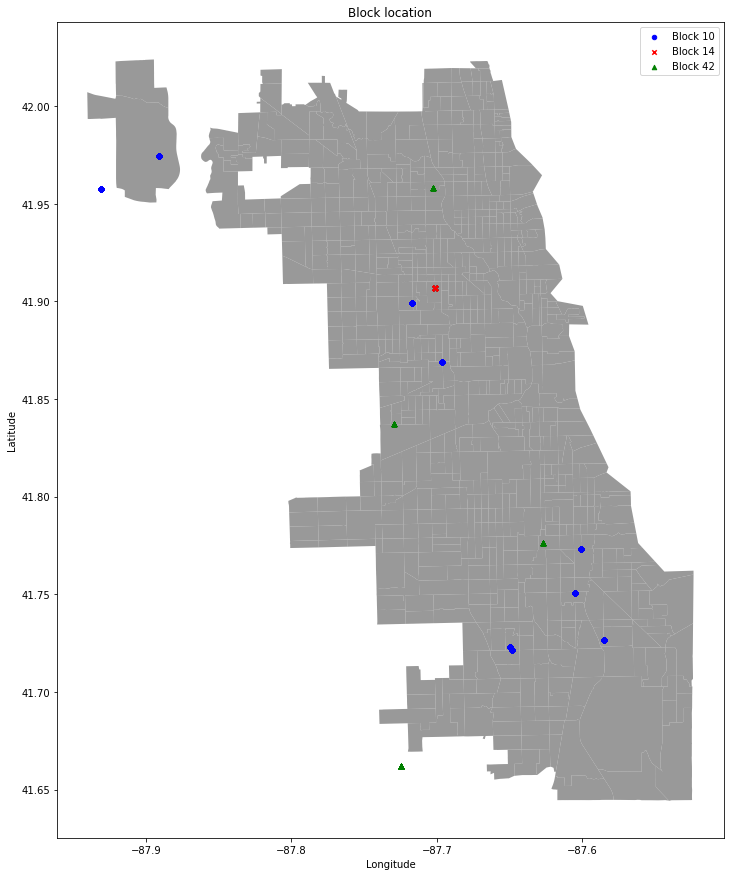

In [20]:
# Trying to visualize if block are specific areas

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[geo_df['Block'] == 10].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Block 10')
geo_df[geo_df['Block'] == 14].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Block 14')
geo_df[geo_df['Block'] == 42].plot(ax = ax, markersize = 20, color = 'green', marker = '^', label = 'Block 42')
plt.title('Block location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/blocks.png')

From our first look at the data, we were wondering if 'Block' represented a particular area/neighbourhood of the city and could be used to map mosquitoes or virus to a particular area of the city

Using the graph above, we can conclude that blocks are not specific areas of the city and can't be used to map mosquitoes or Virus to a specific area of the city

##### Virus Repartition

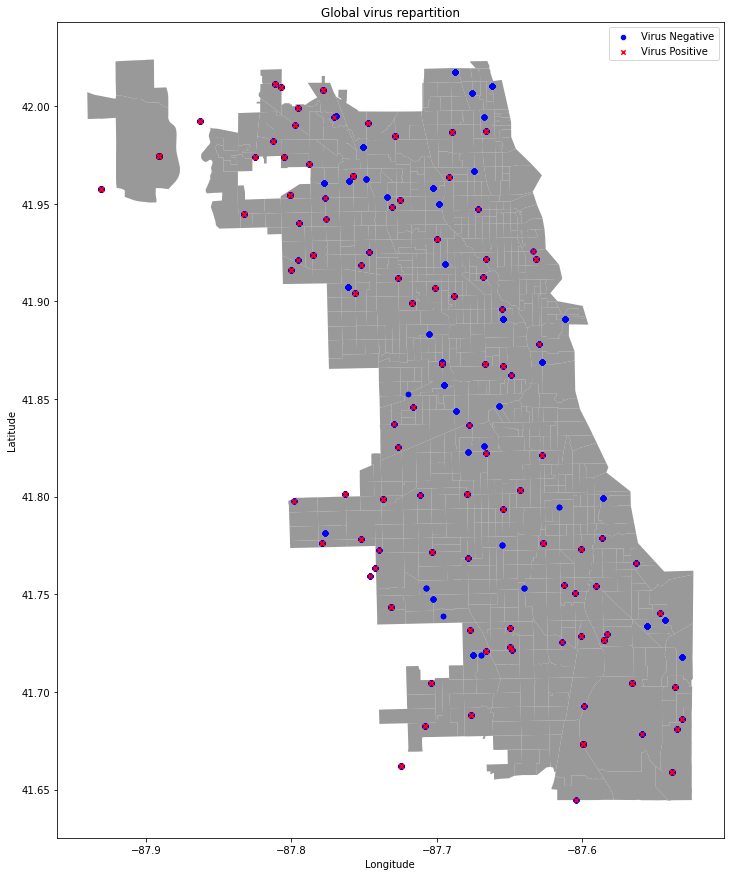

In [21]:
# See Global virus repartition

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[geo_df['WnvPresent'] == 0].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[geo_df['WnvPresent'] == 1].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.title('Global virus repartition')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/global_wnv.png')

From the graph above, we can see that Mosquitos carrying the virus have been identifed throughout the whole city and are not limited to a particular area of the city.

This means that if we focus our spray efforts on only zone where positive mosquitos have been detected we would have to spray the whole city. 

Let's see if the area of the city with positive mosquitoes have changed throughout the years.

###### 2007

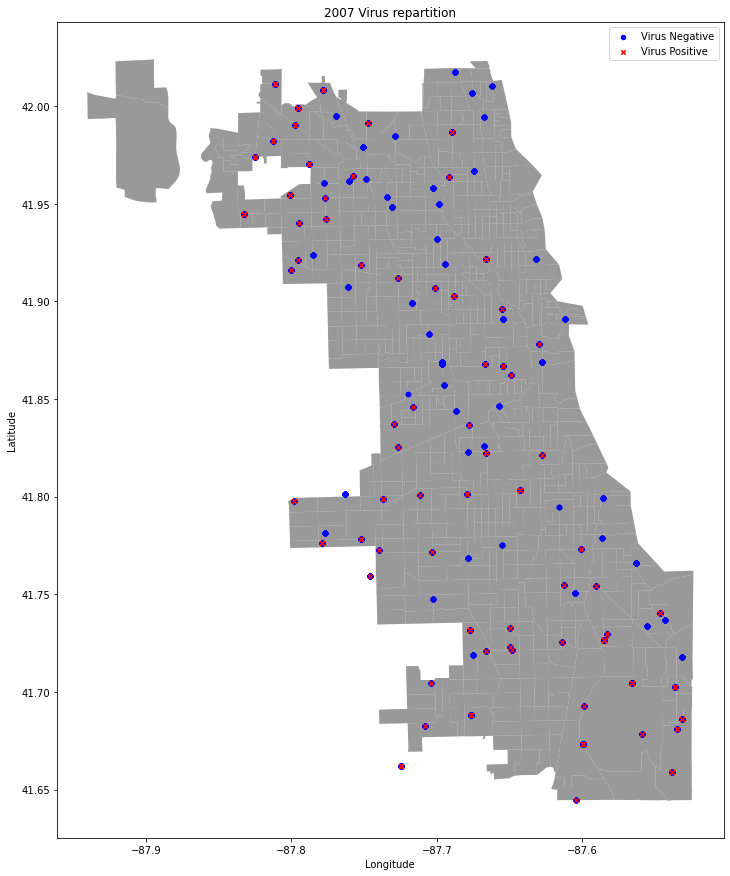

In [22]:
# See virus repartition for 2007

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2007)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2007)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.title('2007 Virus repartition')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2007_wnv_repartition.png')

##### 2009

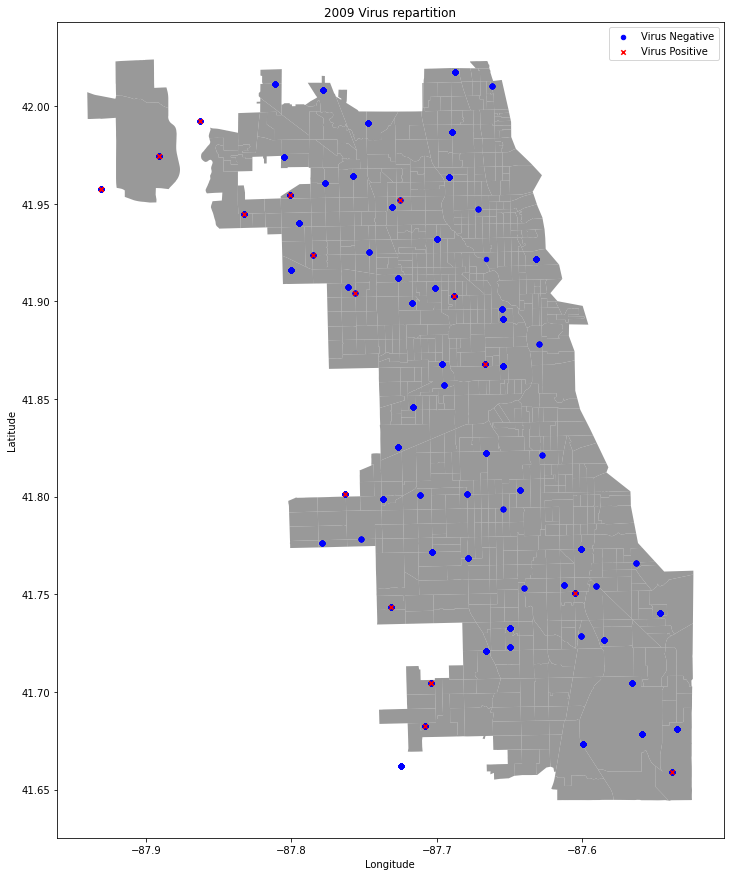

In [23]:
# See virus repartition for 2009

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2009)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2009)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.title('2009 Virus repartition')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2009_virus_repartition.png')

###### 2011

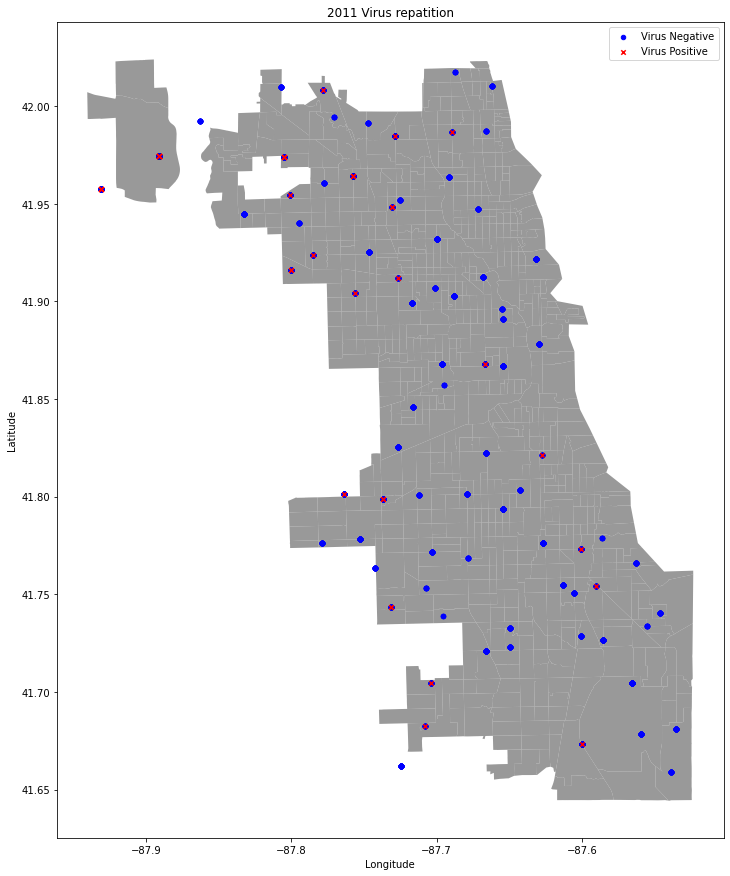

In [24]:
# See virus repartition for 2011

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2011)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2011)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.title('2011 Virus repatition')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2011_virus_repartition.png')

###### 2013

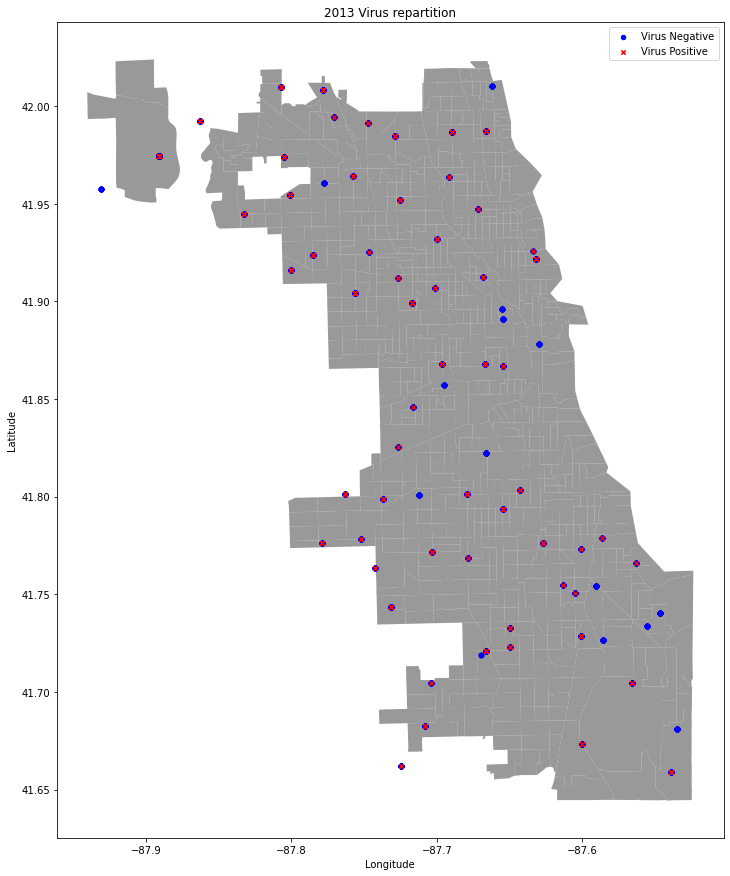

In [25]:
# See virus repartition for 2013

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2013)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2013)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.title('2013 Virus repartition')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2013_virus_repartition.png')

###### Global

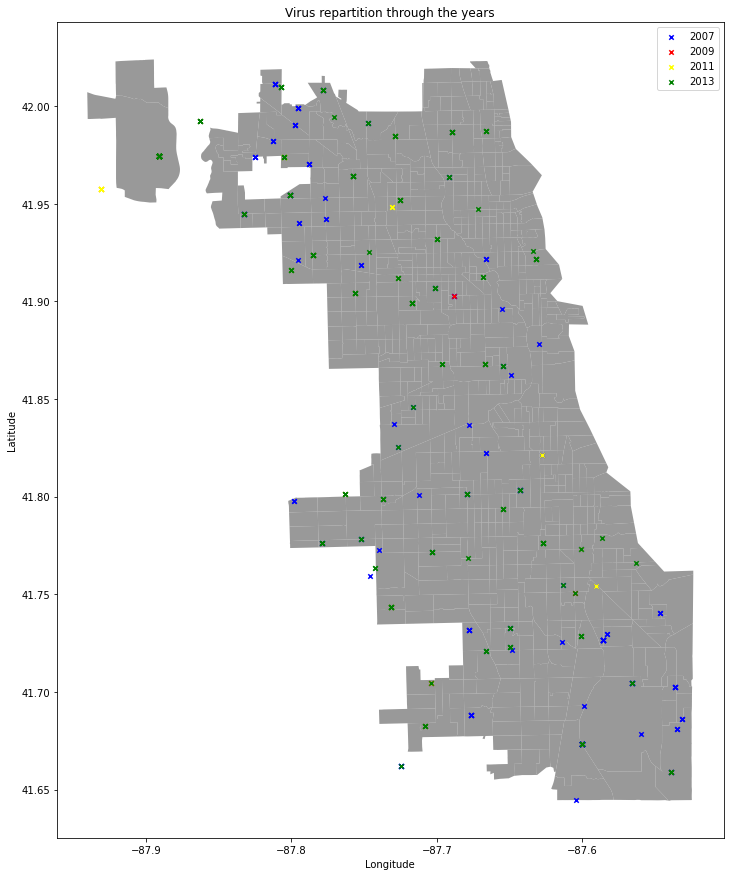

In [26]:
# Positive Virus repartition through the years

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2007)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = '2007')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2009)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = '2009')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2011)].plot(ax = ax, markersize = 20, color = 'yellow', marker = 'x', label = '2011')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2013)].plot(ax = ax, markersize = 20, color = 'green', marker = 'x', label = '2013')
plt.title('Virus repartition through the years')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/global_positive_virus.png')

<font color='red'>/!\ Points are overlapping and we only see the highest layer (2013).

<font color='red'>Be mindfull when using this graph

From the above graphs, we can see that the areas where mosquitos carrying the Wnv virus have been detected are consistent throughout the years. 

There doesn't seem to be a particular area where mosquitos are more likely to carry the virus each year.

Let's now have a look at mosquito density throughout different areas of Chicago and see if we can find interesting insight

##### Mosquitoes habitat and density

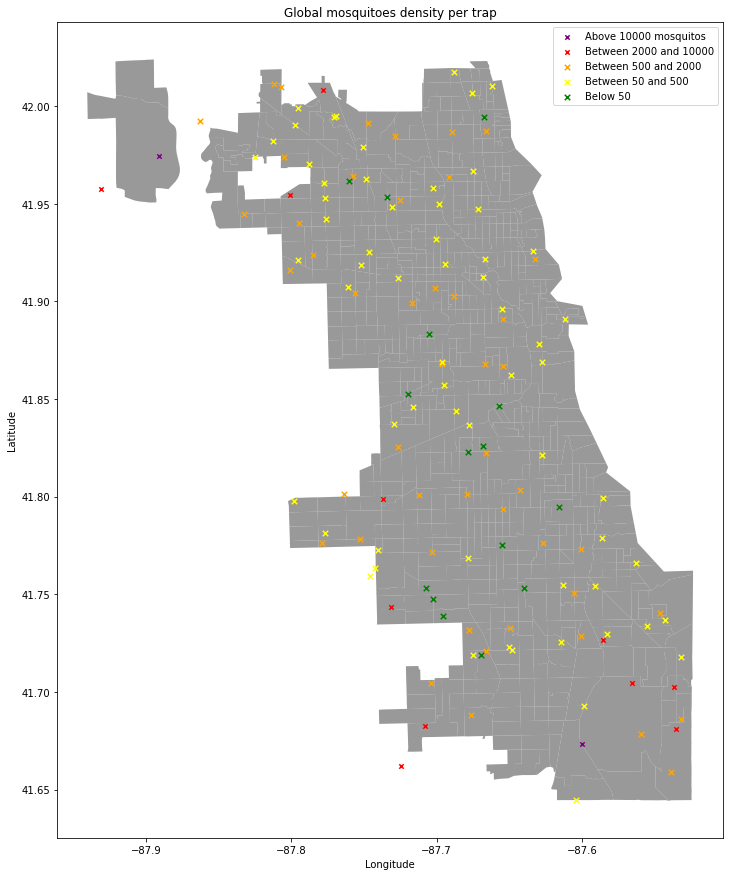

In [27]:
# Mosquitoes density

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_mawnv[(spray_mawnv['NumMosquitos'] > 10000)].plot(ax = ax, markersize = 20, color = 'purple', marker = 'x', label = 'Above 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 10000) & (spray_mawnv['NumMosquitos'] >= 2000)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Between 2000 and 10000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 2000) & (spray_mawnv['NumMosquitos'] >= 500)].plot(ax = ax, markersize = 30, color = 'orange', marker = 'x', label = 'Between 500 and 2000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'yellow', marker = 'x', label = 'Between 50 and 500')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 50)].plot(ax = ax, markersize = 30, color = 'green', marker = 'x', label = 'Below 50')
plt.title('Global mosquitoes density per trap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/global_density.png')

In [28]:
# Display Mosquito concentration and relation with Virus

fig = px.scatter_mapbox(mosquito_areas_wnv, lat = 'Latitude', lon  = 'Longitude', color = 'WnvPresent',
                        #animation_frame='Date',
                        size = 'NumMosquitos', color_continuous_scale=px.colors.cyclical.IceFire,
                        hover_data = ['NumMosquitos', 'WnvPresent'],
                       zoom = 9)
fig.show()

Mosquitoes are found throughout the city of Chicago, however, the number of mosquitoes seem to vary from locations to other.

There are two areas with very high concentration of mosquitoes.
* Lake Calumet and industrial South Deering area
* East side of O'Hare Airport

For area with a high concentration of mosquitoes, they seem to be located in green and water point areas like:
* West O'Hare airport
* Wolf Lake - Eggers Grove
* Vet's Park
* Marian Byrnes Park and Natural area
* Wildwood park
* Park 601

or around green neighbourhoods of houses:
* Scottsdale
* Archer Heights
* South Mount Greenwood (close to Oak Hill Cemetery)

It seems that mosquito population seems to thrive in greener areas (Parks, Marshes) where body of permanent or semi-permanent water can be found. They are also found in high numbers in more industrial areas of the city (O'Hare airport and South Deering Area). 



##### Spray efforts from the Chicago City

The city of Chicago has sprayed some areas of the city in both 2011 and 2013.

This spraying was done in order to reduce the population of mosquitos.

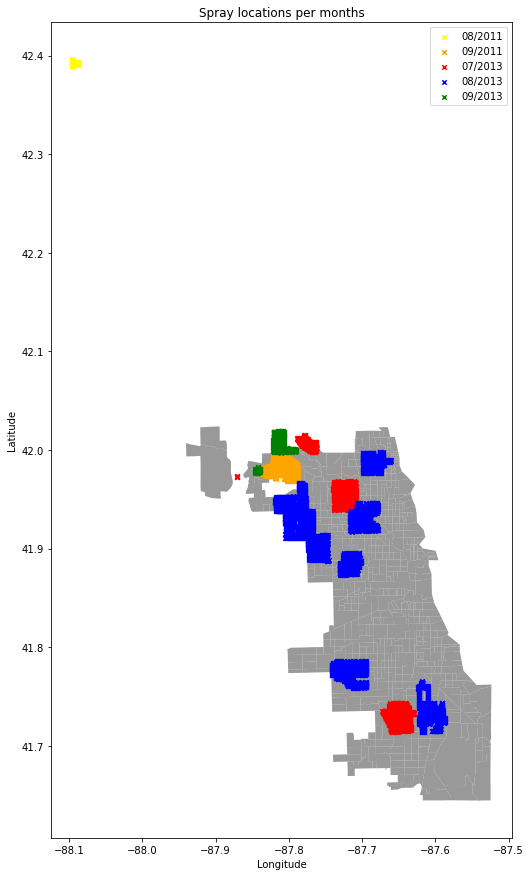

In [29]:
# Spray locations for 2011 and 2013

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 8) ].plot(ax = ax, markersize = 20, color = 'yellow', marker = 'x', label = '08/2011')
spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'orange', marker = 'x', label = '09/2011')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 7) ].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = '07/2013')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 8) ].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = '08/2013')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'green', marker = 'x', label = '09/2013')
plt.title('Spray locations per months')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/global_spray.png')

The city of Chicago has done 54 waves of spraying between 2011 and 2013
* Two in 2011
* Three in 2013

It seems that during August 2011, the city has either sprayed an area far out of town or that the coordinates data provided is incorrect. In any case, we will not be making use of this data as it negatively impacts our map

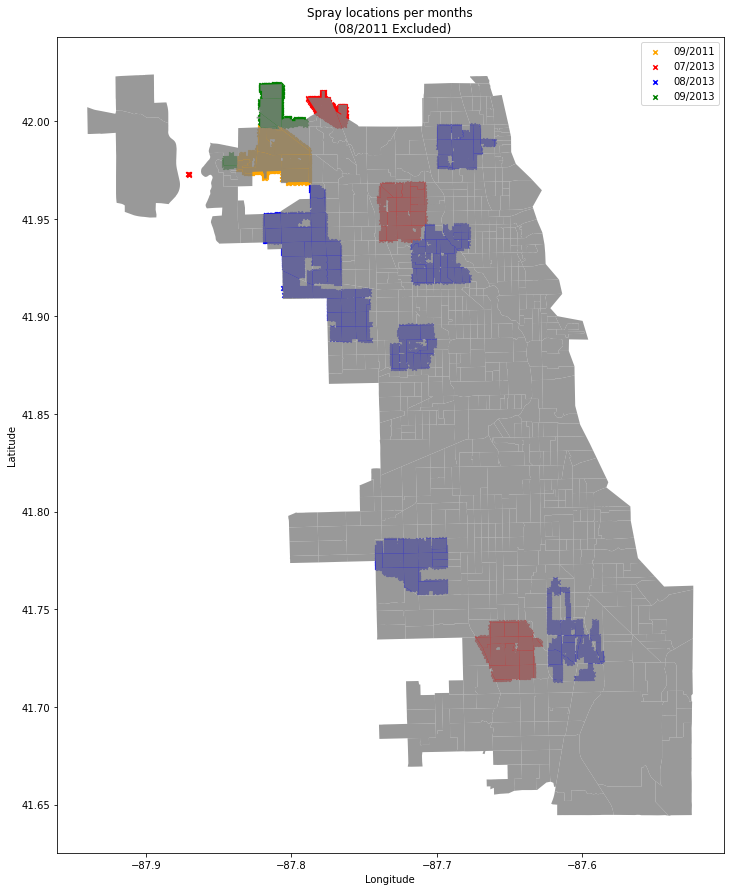

In [30]:
# Spray locations for 2011 and 2013 (without August 2011)

fig,ax = plt.subplots(figsize =(15,15))

spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'orange', marker = 'x', label = '09/2011')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 7) ].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = '07/2013')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 8) ].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = '08/2013')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'green', marker = 'x', label = '09/2013')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
plt.title('Spray locations per months\n (08/2011 Excluded)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/global_spray.png')

From the graph above, we can see that the areas aprayed are almost exclusively densly populated areas. 

It also seems that they have excluded parks and green areas from the spraying to focus on habitations.

Let's compare the areas sprayed with areas where the virus was detected and the mosquitoes density

###### Spray vs Virus Population

###### 2011

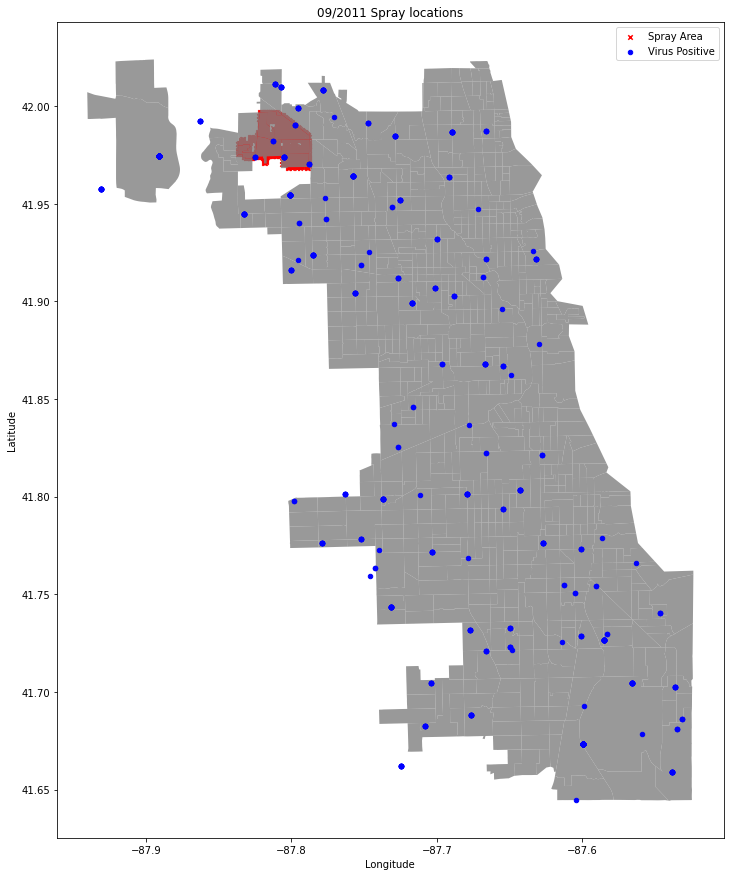

In [31]:
# Spray for September 2011 compared to positive virus locations

fig,ax = plt.subplots(figsize =(15,15))

spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Spray Area')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[geo_df['WnvPresent'] == 1].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Positive')
plt.title('09/2011 Spray locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2011_09_spray.png')

We can see that in September 2011, the city of chicago has concentrated it's spray effort on a limited area north west of the city.

This area correspond to Norwood Park and Orile Park. The most notable landmark in this area is the Ascension Resurection Medical Center.



###### 2013

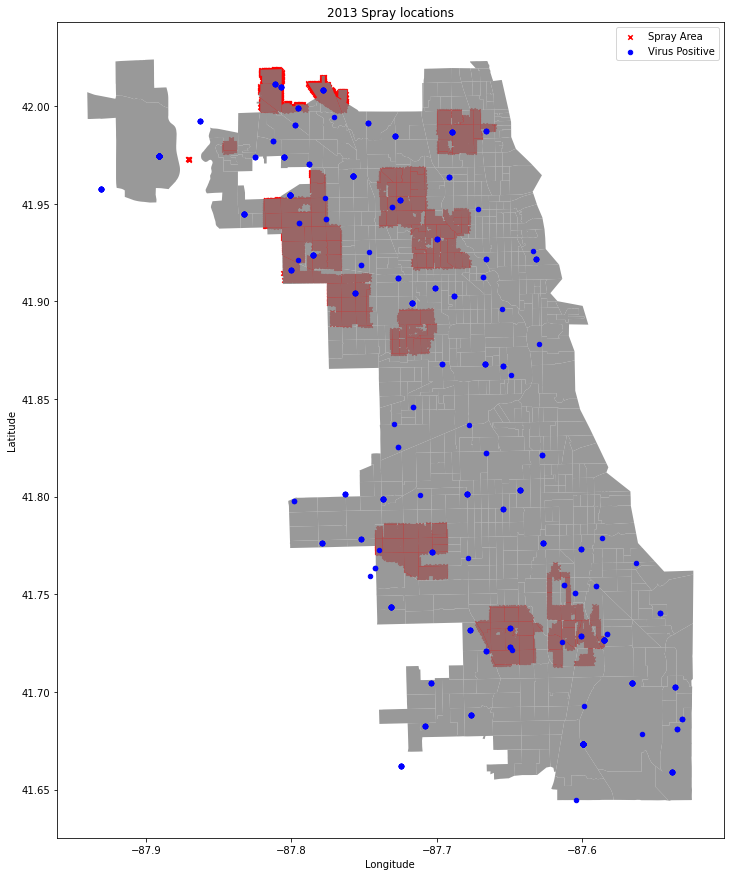

In [32]:
# Spray for 2013 compared to positive virus locations

fig,ax = plt.subplots(figsize =(15,15))

spray_df[spray_df['year'] == 2013].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Spray Area')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[geo_df['WnvPresent'] == 1].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Positive')
plt.title('2013 Spray locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2013_spray.png')

During 2013 however, we can see that the city has intensified it's spray efforts and broadened it to more locations throughout the city.

If we compare these locations to the city layout, we can see that all the areas sprayed are urban areas.

They have clearly avoided spraying parks and green areas

###### Spray vs Mosquitoes Population

###### 2011

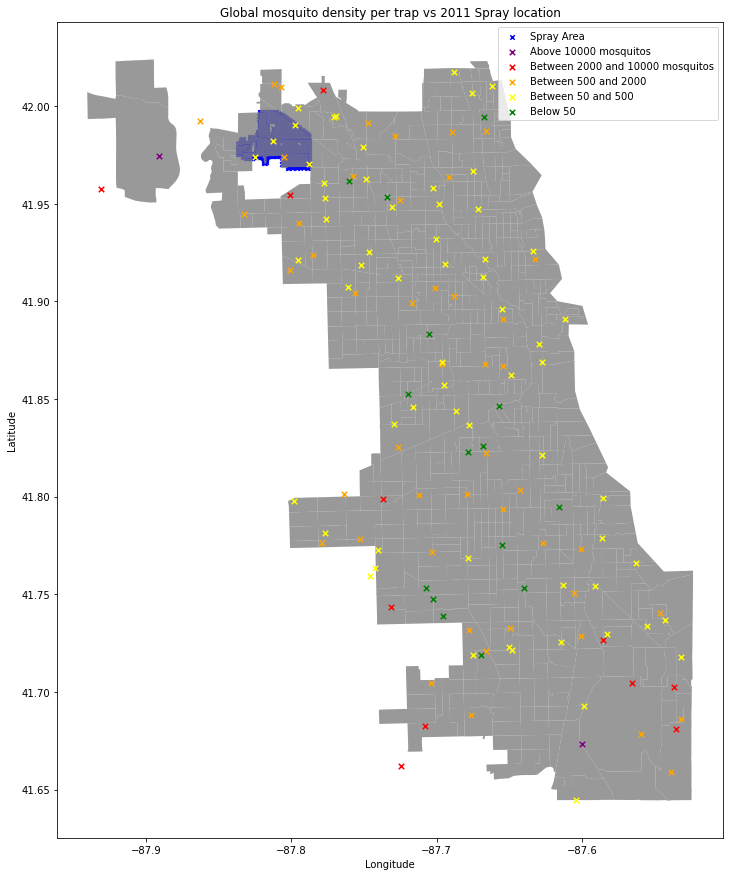

In [33]:
# Compare number of mosquitos with areas sprayed 2011

fig,ax = plt.subplots(figsize =(15,15))

spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = 'Spray Area')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_mawnv[spray_mawnv['NumMosquitos'] >= 10000].plot(ax = ax, markersize = 30, color = 'purple', marker = 'x', label = 'Above 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 10000) & (spray_mawnv['NumMosquitos'] >= 2000)].plot(ax = ax, markersize = 30, color = 'red', marker = 'x', label = 'Between 2000 and 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 2000) & (spray_mawnv['NumMosquitos'] >= 500)].plot(ax = ax, markersize = 30, color = 'orange', marker = 'x', label = 'Between 500 and 2000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'yellow', marker = 'x', label = 'Between 50 and 500')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 50)].plot(ax = ax, markersize = 30, color = 'green', marker = 'x', label = 'Below 50')
plt.title('Global mosquito density per trap vs 2011 Spray location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2011_spray_vs_density.png')

If we compare the areas sprayed with the areas with higher concentration of mosquitos, we can see that in 2011, the area that was sprayed was not among the highest mosquito density at all.

It was done in an area with relatively low concentration of mosquitos.

###### 2013

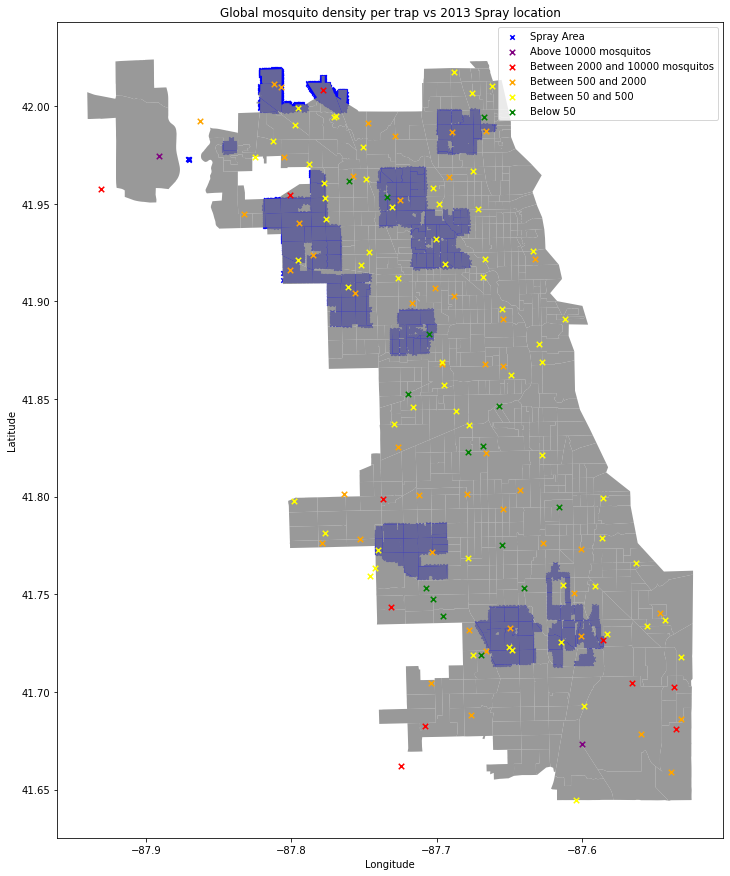

In [37]:
# Compare number of mosquitos with areas sprayed 2013

fig,ax = plt.subplots(figsize =(15,15))

spray_df[spray_df['year'] == 2013].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = 'Spray Area')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_mawnv[spray_mawnv['NumMosquitos'] >= 10000].plot(ax = ax, markersize = 30, color = 'purple', marker = 'x', label = 'Above 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 10000) & (spray_mawnv['NumMosquitos'] >= 2000)].plot(ax = ax, markersize = 30, color = 'red', marker = 'x', label = 'Between 2000 and 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 2000) & (spray_mawnv['NumMosquitos'] >= 500)].plot(ax = ax, markersize = 30, color = 'orange', marker = 'x', label = 'Between 500 and 2000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'yellow', marker = 'x', label = 'Between 50 and 500')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 50)].plot(ax = ax, markersize = 30, color = 'green', marker = 'x', label = 'Below 50')
plt.title('Global mosquito density per trap vs 2013 Spray location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/2013_spray_vs_density.png')

###### Global

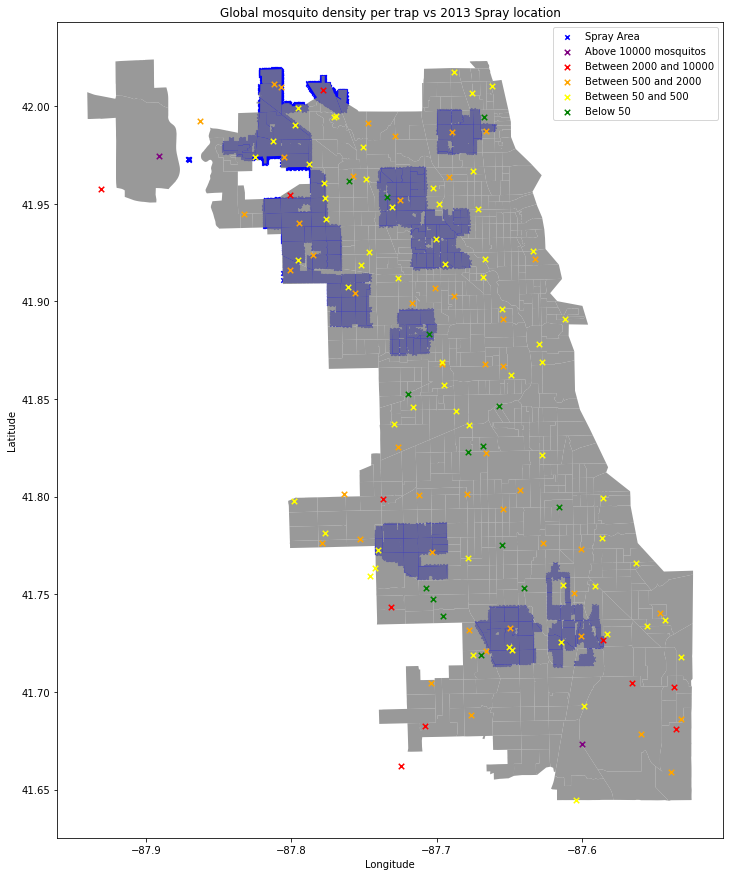

In [39]:
# Compare number of mosquitos with areas sprayed Global

fig,ax = plt.subplots(figsize =(15,15))

spray_df[(spray_df['year'] == 2013)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = 'Spray Area')
spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_mawnv[spray_mawnv['NumMosquitos'] >= 10000].plot(ax = ax, markersize = 30, color = 'purple', marker = 'x', label = 'Above 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 10000) & (spray_mawnv['NumMosquitos'] >= 2000)].plot(ax = ax, markersize = 30, color = 'red', marker = 'x', label = 'Between 2000 and 10000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 2000) & (spray_mawnv['NumMosquitos'] >= 500)].plot(ax = ax, markersize = 30, color = 'orange', marker = 'x', label = 'Between 500 and 2000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'yellow', marker = 'x', label = 'Between 50 and 500')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 50)].plot(ax = ax, markersize = 30, color = 'green', marker = 'x', label = 'Below 50')
plt.title('Global mosquito density per trap vs 2013 Spray location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.savefig('data/charts/global_spray_vs_density.png')

In [35]:
# Spray areas vs Mosquitoes and virus density

fig = px.scatter_mapbox(spray, lat = 'Latitude', lon  = 'Longitude',#animation_frame = 'Date',
                        size_max=15, zoom = 9,color_discrete_sequence=["palegoldenrod"],  opacity = 0.5)

fig2 = px.scatter_mapbox(mosquito_areas_wnv, lat = 'Latitude', lon  = 'Longitude', color = 'WnvPresent',
                        size = 'NumMosquitos', color_continuous_scale=px.colors.cyclical.IceFire,
                        hover_data = ['NumMosquitos', 'WnvPresent'],
                       zoom = 9)

fig.add_trace(fig2.data[0],)

fig.update_layout( title = 'Spray - West Nile Virus and Mosquito clusters',
                width=500,
    height=700,)

For 2013, we have a similar result as 2011.

Areas that were sprayed are not among the areas with the highest population of mosquitoes (with the exception of the furthest north area of Wildwood/North Edgebrook).
* Belmont Cragin/Garden has even been sprayed despite having a recorded population of less than 50 mosquitoes in the traps.

Once again, they also have clearly avoided parks and green areas to focus on habitations.



##### Spraying costs and optimisations

Surface sprayed per years:

|          	|               Area Name              	| km/sqr 	| mil/sqr 	|  acres  	|
|----------	|:------------------------------------:	|:------:	|:-------:	|:-------:	|
| **2011** 	| Union Ridge, Old Norwood Oriole Park 	| 8.48   	| 3.27    	| 2095.45 	|




|           	|                        Area Name                        	| km/sqr 	| mil/sqr 	|   acres  	|
|-----------	|:-------------------------------------------------------:	|:------:	|:-------:	|:--------:	|
|           	| Edison Park Area                                        	| 3.50   	| 1.35    	|          	|
|           	| North Edgebrook Wildwood                                	| 2.01   	| 1.24    	|          	|
|           	| Arcadia Terrace Bowmanville                             	| 5.03   	| 1.94    	|          	|
|           	| Irving Park, Avondale Palmer Square, Bucktown Bricktown 	| 18.92  	| 7.31    	|          	|
| **2013**  	| Dunning, Montclare Belmont, Austin                      	| 22.84  	| 8.82    	|          	|
|           	| Garfield Park                                           	| 6.20   	| 2.39    	|          	|
|           	| West Lawn                                               	| 9.47   	| 3.66    	|          	|
|           	| Brainerd, Longwood Manor                                	| 8.17   	| 3.15    	|          	|
|           	| Burnside, Chatham                                       	| 7.66   	| 2.96    	|          	|
| **Total** 	|                                                         	| 83.8   	| 32.35   	| 20707.43 	|

In 2013, the city of Chicago has sprayed a surface 10 time bigger than in 2011.


Important Information:
* It uses Zenivex insecticides to kill adult mosquitoes when West Nile Virus infected mosquitoes have been detected
    * From July to September
* Insecticide is sprayed by a truck mounted fogger in a process called Ultra Low Volume fogging to use small amount of pesticides. Flying mosquitoes are killed by contact with the fog. Mosquito spraying is done at night when mosquitoes are active and traffic is minimal.
    * Spraying is done from Dusk till 1am
    * Each spraying required at least 2 technicians as well as supervisors from Chicago Department of Streets and Sanitations
        * We can assume that they use several trucks and several supervisors teams.
* Only 1.5 ounces of pesticides are needed per acre
* According to Central Mosquito Control, cost of Zenivec E20 is 67c per acre
* According to North Dakota Health Department webiste, Zenivex E4 costs 89.60 per gallon for 30 gallon drums

|      	| Total Acre 	| Ounce per Acre 	| Total Ounces 	| Ounce per Gallon 	| Total Gallon 	| Price for 30 Gallon Drum 	| Number of Drum needed 	| Total Price 	|
|------	|------------	|----------------	|--------------	|------------------	|--------------	|--------------------------	|-----------------------	|-------------	|
| 2011 	|   2095.45  	|       1.5      	|    3143.17   	|        128       	|     24.55    	|           2688           	|           1           	|     2688    	|        9 (8.08)       	|    24192    	|


|      	| Total Acre 	| Ounce per Acre 	| Total Ounces 	| Ounce per Gallon 	| Total Gallon 	| Price for 30 Gallon Drum 	| Number of Drum needed 	| Total Price 	|
|------	|------------	|----------------	|--------------	|------------------	|--------------	|--------------------------	|-----------------------	|-------------	|
| 2013 	|  20707.43  	|       1.5      	|   31,061.14  	|        128       	|    242.66    	|           2688           	|        9 (8.08)       	|    24192    	|
               
               


Proposed spraying plan:

The plan we propose is two parts:
* Spray areas with the highest density of mosquitoes once per year BEFORE/WHEN MOSQUITOES ARE MOST PRESENT
* Spray blocks where positive mosquitoes are detected

This will allow us to regulate the population of mosquitoes and limit the spread between mosquitoes. This will also enable us to do timely spray on positive clusters and reduce chances of mosquitoes transmitting virus to human.



**1. Spray areas with the highest density of mosquitoes:**

|                                            	| km/sqr  	| mil/sqr 	| acres    	|
|--------------------------------------------	|---------	|---------	|----------	|
| O'Hare Airport                             	| 25.58   	| 9.88    	|          	|
| Lake Calumet South Deering Industrial Area 	| 13.96   	| 5.39    	|          	|
| Park 601 Dunning Area                      	| 0.00081 	| 0.00031 	|          	|
| Old Edgebrook Park                         	| 2.63    	| 1.02    	|          	|
| Mount Greenwood, Mount Olivet              	| 1.02    	| 0.39    	|          	|
| Marian R Byrnes Natural Area               	| 0.5     	| 0.2     	|          	|
| Wolf Lake, Lost Marsh                      	| 8.85    	| 3.42    	|          	|
| Scottsdale                                 	| 2.54    	| 1       	|          	|
| **Total**                                  	| 55.89   	| 21.57   	| 13810.72 	|

| Total Acre 	| Ounce per Acre 	| Total Ounces 	| Ounce per Gallon 	| Total Gallons 	| Price for 30 Gallon Drum 	| Number of Drums needed 	| Total Price 	|
|------------	|----------------	|--------------	|------------------	|---------------	|--------------------------	|------------------------	|-------------	|
|  13810.72  	|       1.5      	|   20716.08   	|        128       	|     161.84    	|           2688           	|        6 (5.39)        	|    16128    	|


**2. Timely spray whenever a cluster is detected:**

* Spray 0.15 acres around positive traps (60702.8 meter/sqr - 1 block)
    * 0.225 ounce needed to spray area
        * 128 ounce per gallon/ 0.0018% of a gallon
            * 60 cents per spray.
            
| Total Acre 	| Ounce per Acre 	| Total Ounces 	| Ounce per Gallon 	| Total Gallons 	| Price for 30 Gallon Drum 	| Number of Drums needed 	| Total Price (Per Spray) 	|
|------------	|----------------	|--------------	|------------------	|---------------	|--------------------------	|------------------------	|-------------------------	|
|    0.15    	|       1.5      	|     0.225    	|        128       	|     0.0017    	|           2688           	|            1           	|           0.16          	|   


Let's take the count of positive virus per year:

| 2007 	| 472 	|
|------	|-----	|
| 2009 	| 38  	|
| 2011 	| 114 	|
| 2013 	| 478 	|

We will take the average amount of year 2007 and 2013 as they are the year with the highest amount and are pretty close in terms of number: **475**.
* if we do 475 timely remediation spray throughout each year, it will cost **76 dollar** for Zenivex.

**3. Manpower and logistic costs**

Assuming we need 4 people (2 technicians and 2 Supervisors) in order to spray each area in 2011 and 2013 and that each spraying takes around 5 hours. 
- 16 dollar (20 dollars for night work) per hour for each persones involved. 
    * 400 dollar wages per spray
    
On top of this we need to add logistics and material costs plus maintenance.

Since, we are also targetting parks and green areas, it makes it much harder (impossible) for technicians to spray using trucks.

Instead, we would recommend the usage of drones to reach and spray over these harder to reach places. They would also be useful whe it comes to precise spraying, allowing for more targeted applications.

Acquisition and maintenance of drones is cheaper than fleet of trucks
Two persons needed to apply the spray using the drone.
* Drones have limited capacity, but would be perfect for the timely sprays covering small areas.

### Conclusion


From our analysis, it seems that the spraying efforts in 2011 and 2013 are not very efficient to reduce the population of mosquitoes in the city of Chicago. 

* The two main areas with the highest density of mosquitoes (O'Hare Airport and Lake Calumet/industrial South Deering area) have not been sprayed by the city despite having a number of mosquitoes far superior to other areas of the city.
* Most of the areas sprayed are habitation areas with a relatively low concentration of mosquitoes. 

Even though the focus should be reducing the risk of human getting infected by the west nile virus, we believe that spraying areas with higher concentration of mosquitoes would be a better course of action.

Since we also know that higher concentration of mosquitoes also equals to more mosquitoes carrying the Wnv, reducing the population of mosquitoes appears to be a necessity.
* Since the spread of Wnv to mosquitoes is done through birds infected by other mosquitoes, reducing clusters of mosquitoes would reduce the chances of birds getting infected by mosquitoes.
* If less birds are being infected by mosquitoes, they are also less likely to transmit the virus to other mosquitoes
* This ultimately would lead to less mosquitoes being able to transmit the virus to humans.

### Recommendations

* Focus periodic spraying efforts on parks and green areas that have a higher concentration of mosquitoes instead of habitations areas
* Do timely spraying efforts in areas where virus outbreaks are detected
    . This can also be done through the use of drone to reduce the manpower cost and reach areas that a truck spraying pesticide wouldn't be able to reach.